# Автор: Серегин Михаил


In [131]:
import pandas as pd
import numpy as np
import random
from surprise import Dataset
from surprise import Reader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import r_regression
from sklearn.metrics import pairwise_distances
import tqdm
import surprise.prediction_algorithms.knns
import matplotlib.pyplot as plt

# KNNWithMeans

In [122]:
class KNNWithMeans:
    def __init__(self, k=40, user_based=True, metric="cosine"):
        self.k = k
        self.axis = 1 if user_based else 0
        assert metric == "cosine"
        self.metric = metric
        assert type(user_based) is bool
        self.user_based = user_based if user_based else False
        
    def fit(self, df_training):

        df = df_training.copy()
        df.index = range(len(df.index))  # индексация начинается с 0!
        df.columns = range(len(df.columns))

        not_null_users = np.array(df.notnull().sum(axis=1))  + 0.00000001 
        not_null_items = np.array(df.notnull().sum(axis=0)) + 0.00000001
        self.x_train = df.fillna(0)       
        self.mu_users = np.array(df.fillna(0).sum(axis=1) / not_null_users)
        self.mu_items = np.array(df.fillna(0).sum(axis=0) / not_null_items)
            
        if not self.user_based:
            self.x_train = self.x_train.T        
        
        self.comput_neighbourhood() # подсчет попарных расстояний
    
    def comput_neighbourhood(self,):
        """
        Функция ищет расстояние от каждого пользователя до каждого
        a_ij = расстояние от i до j
        """

        if self.metric == "cosine":
            self.dist = cosine_similarity(self.x_train)
            self.argsort_dist = np.argsort(self.dist,axis=1)[:,::-1] # id тех пользователей, которые наиболее близки

        return
    
    def check_rating_exsists(self, potential_similar_user, item):
        """
        Returns unbiased rating of item if exists, else False.
        """

        out = self.x_train.iloc[potential_similar_user,item]
        if out == 0:
            return False
        else:
            mu = self.mu_users[potential_similar_user] if self.user_based else self.mu_items[potential_similar_user]
            return out - mu

    def score_without_mu(self, user, item):
        """
        Для пользователя user расчитывает сглаженную оценку предмета item,
        путем усреднения с весами разницы между среднеми оценками близких пользователей и оценкой данной предмету item.
        """

        arr_user_dist = self.dist[user]
        arr_argsort_nearest = self.argsort_dist[user][1:]
        lst_sim_nearest = []
        lst_ratings = []
        for potential_similar_user in arr_argsort_nearest:
            if len(lst_sim_nearest) == self.k:
                break
            
            rating_if_exists = self.check_rating_exsists(potential_similar_user, item) # возвращает unbiased rating if exists else 0
            if rating_if_exists is not False:
                lst_sim_nearest.append(arr_user_dist[potential_similar_user])
                lst_ratings.append(rating_if_exists)
      
        # на этом этапе уже собрали два списка, содержащие несмещенные рейтинги и расстояния до них. 
        
        if np.sum(np.array(lst_sim_nearest)) == 0: # что лучше возвращать сначала?

            if self.mu_items[item] != 0:

                return self.mu_items[item]
            elif self.mu_users[user] != 0:

                return self.mu_users[user]
            else:
   
                return np.mean(self.mu_items[item])
                
        return np.sum(np.array(lst_sim_nearest) * np.array(lst_ratings)) / np.sum(np.array(lst_sim_nearest))
        
    def predict(self, pivot_):
        """
        Функция предсказывает рейтинги по поданной на вход сводной таблице,
        первым столбцом которой является номер пользователя, вторым номером товара. 
        
        Вход: сводная таблица, с произвольным индексом. 
        Первый столбец - столбец users, если считать их с 1. Второй столбец - индекс товара, считая также с 1
        Выход: массив предсказаний. 
        
        """
        pivot = pivot_.copy()
        pred = np.zeros(shape=len(pivot.index))

        
        for i in range(len(pivot.index)):
            user, item = list(map(int, list(pivot.iloc[i]))) if self.user_based else list(map(int, list(pivot.iloc[i])))[::-1]
            # user and item приходит, однако его id в нашей матрице -  user-1
            
            user -= 1
            item -= 1
            plus = self.score_without_mu(user, item) 
            
            r_ui = self.mu_users[user] + plus if self.user_based else self.mu_items[user] + plus
            
            pred[i] = r_ui
            
        return np.clip(pred, 1,5)

Тестирование

In [3]:
"""
Класс содержит собственные тесты для простого датасета
"""
class TestWithMeans:
    def __init__(self,):
        data = np.array([[4.0,  np.nan,  np.nan,  3.0], [4.0 , 1.0 , 4.0,  4.0],[np.nan , 1.0 ,np.nan , np.nan],[1.0 , 2.0  ,1.0  ,1.0]])
        
        self.df_test = pd.DataFrame(data, index=range(1,5),columns=range(1,5))
        
        pivot = self.df_test.copy()
        pivot["id"] = pivot.index
        pivot = pd.melt(pivot, id_vars="id")
        pivot.dropna(inplace=True)
        pivot_test = pivot.iloc[:4]
        pivot_test.index = range(len(pivot_test.index))
        del pivot_test["value"]
        
        self.pivot_test = pivot_test

    
    def k1(self,):
        ans = []
        for user_based in [True, False]:
            knn = KNNWithMeans(k=1,user_based=user_based)
            knn.fit(self.df_test)
            pred = knn.predict(self.pivot_test)
            pred_true = np.array([4.25,3.75,2.,4.]) if user_based else np.array([3.33, 4.33, 1.33, 2.83])
            ans.append(np.all(np.abs(pred-pred_true) <0.01))
            
        assert np.all(np.array(ans))
            
        
        
    def k2(self,):
        ans = []
        for user_based in [True, False]:
            knn = KNNWithMeans(k=2,user_based=user_based)
            knn.fit(self.df_test)
            pred = knn.predict(self.pivot_test)
            pred_true = np.array([3.85, 3.38, 1.89, 3.880]) if user_based else np.array([3.333, 4.403, 1.403, 2.758])
            ans.append(np.all(np.abs(pred-pred_true) <0.01))
        assert np.all(np.abs(pred-pred_true) <0.01)
        
    def k3(self,):
        ans = []
        for user_based in [True, False]:
            knn = KNNWithMeans(k=3,user_based=user_based)
            knn.fit(self.df_test)
            pred = knn.predict(self.pivot_test)
            pred_true = np.array([3.85, 3.38, 1.89, 3.88]) if user_based else np.array([3.333, 4.056, 1.855, 2.637])
            ans.append(np.all(np.abs(pred-pred_true) <0.05))
        assert np.all(np.abs(pred-pred_true) <0.01)
        
    def __call__(self):
        self.k1()
        self.k2()
        self.k3()
        
        

In [4]:
def small():
    data = np.array([[4.0,  np.nan,  np.nan,  3.0], [4.0 , 1.0 , 4.0,  4.0],[np.nan , 1.0 ,np.nan , np.nan],[1.0 , 2.0  ,1.0  ,1.0]])
    df_test = pd.DataFrame(data, index=range(1,5),columns=range(1,5))
    mask = ~df_test.isna().to_numpy()
    R = df_test.fillna(0).to_numpy()
    return R, mask

In [5]:
test = TestWithMeans()
test()

# KNNBasic

In [113]:
class KNNBasic:
    
    def __init__(self, k=40, user_based=True, metric="cosine"):
        self.k = k
        assert metric == "cosine"
        self.metric = metric
        assert type(user_based) is bool
        self.user_based = user_based if user_based else False
        
        
        
    def fit(self, df_training):
        """
        """
        df = df_training.copy()
        df.index = range(len(df.index))  # индексация начинается с 0!
        df.columns = range(len(df.columns))

        not_null_users = np.array(df.notnull().sum(axis=1)) + 0.000001
        not_null_items = np.array(df.notnull().sum(axis=0)) + 0.000001
        self.x_train = df.fillna(0)       # заполняем пропущенные значения нулями
        self.mu_us = np.array(df.fillna(0).sum(axis=1) / not_null_users)
        self.mu_it = np.array(df.fillna(0).sum(axis=0) / not_null_items)
            
        if not self.user_based:
            self.x_train = self.x_train.T
        
        # здесь можно расчитать попарные расстояния
        self.comput_neighbourhood()

    
    def comput_neighbourhood(self,):
        """
        Функция ищет расстояние от каждого пользователя до каждого
        a_ij = расстояние от i до j
        
        """

        if self.metric == "cosine":
            self.dist = cosine_similarity(self.x_train)
            self.argsort_dist = np.argsort(self.dist,axis=1)[:,::-1] # id тех пользователей, которые наиболее близки

        return
    
    def check_rating_exsists(self, potential_similar_user, item):
        """
        Returns unbiased rating of item if exists, else False.
        """
        out = self.x_train.iloc[potential_similar_user,item]

        if out == 0:
            return False
        else:
            return out
    
    def score_without_mu(self, user, item):
        """
        Для пользователя user расчитывает сглаженную оценку предмета item,
        путем усреднения с весами разницы между среднеми оценками близких пользователей и оценкой данной предмету item.
        """
        arr_user_dist = self.dist[user] # убрал индексацию 
        arr_argsort_nearest = self.argsort_dist[user][1:]

        lst_sim_nearest = []
        lst_ratings = []
        for potential_similar_user in arr_argsort_nearest:
            if len(lst_sim_nearest) == self.k:
                break
                
            
            rating_if_exists = self.check_rating_exsists(potential_similar_user, item) # возвращает unbiased rating if exists else 0

            if rating_if_exists is not False:
                lst_sim_nearest.append(arr_user_dist[potential_similar_user])
                lst_ratings.append(rating_if_exists)
      
        # на этом этапе уже собрали два списка, содержащие несмещенные рейтинги и расстояния до них.       
        if np.sum(np.array(lst_sim_nearest)) == 0: # что лучше возвращать сначала?
            if self.mu_it[item] != 0:
                return self.mu_it[item]
            elif self.mu_us[user] != 0:
                return self.mu_us[user]
            else:
                return np.mean(self.mu_it)
                
            
        return np.sum(np.array(lst_sim_nearest) * np.array(lst_ratings)) / np.sum(np.array(lst_sim_nearest))
        
    def predict(self, pivot_):
        """
        Функция предсказывает рейтинги по поданной на вход сводной таблице,
        первым столбцом которой является номер пользователя, вторым номером товара. 
        
        Вход: сводная таблица, с произвольным индексом. 
        Первый столбец - столбец users, если считать их с 1. Второй столбец - индекс товара, считая также с 1
        Выход: массив предсказаний. 
        
        """
        pivot = pivot_.copy()
        pred = np.zeros(shape=len(pivot.index))

        
        for i in range(len(pivot.index)):
            user, item = list(map(int, list(pivot.iloc[i]))) if self.user_based else list(map(int, list(pivot.iloc[i])))[::-1]
            # user and item приходит, однако его id в нашей матрице есть user - 1
            
            user -= 1
            item -= 1
            plus = self.score_without_mu(user, item) 
            pred[i] = plus
            
            

        return np.clip(pred, 1,5)

In [7]:
def pivot_to_df(pivot_, user, item, rating):
    """
    Функция по поданной сводной таблице строит pandas.DataFrame. 
    Вход: сводная таблица, например 
    >>> data = Dataset.load_builtin('ml-100k')
    Выход: pandas.DataFrame
    """
    pivot = pivot_.copy()
    pivot[user] = pivot[user].astype(int)
    pivot[item] = pivot[item].astype(int)
    pivot[rating] = pivot[rating].astype(int)

    new_df = pd.DataFrame(index=range(1, max(pivot[user])+1), columns=range(1, max(pivot[item])+1))

    for i in pivot.index:
        curuser, curitem, currating = pivot.iloc[i]

        new_df.loc[curuser,curitem] = currating

        
    return new_df 

# SVD

In [700]:
class SVD:
    def __init__(self,method="SGD", n_factors=5, n_epochs=10, lr=0.001,reg=0.02,random_state=1):
        self.method = method
        self.n_epochs = n_epochs
        self.n_factors = n_factors
        self.reg = reg
        self.random_state = random_state
        self.lr=lr
    
        
    def compute_us_U(self,RR, P,Q, I,mu, mask, notna_1):
        us = (np.sum((RR - P@Q - I - mu)*mask,axis=1)/notna_1).reshape(-1,1) # уцмножаю на маску, чтобы усреднение делать только по известным меткам
        U = us*np.ones_like(RR)
        return us, U

    def compute_it_I(self,RR,P,Q,U,mu, mask, notna_0):
        it = np.sum((RR - P@Q - U - mu)*mask, axis=0) / notna_0
        I = it*np.ones_like(RR)
        return it, I
    
    def _sgd(self,df_train):
        np.random.seed(1)
        random.seed(1)
        
        RR = df_train.fillna(0).to_numpy()
        mask = RR != 0
        not_null = mask.sum()

        P = np.random.random((RR.shape[0],self.n_factors))
        Q = np.random.random((self.n_factors,RR.shape[1]))

        us = np.random.random((RR.shape[0],1))
        it = np.random.random((1,RR.shape[1]))

        U = us*np.ones_like(RR) 
        I = it*np.ones_like(RR)

        mu = np.ones_like(RR) * RR.sum() / not_null

        notna_0 = mask.sum(axis=0) + 0.00001
        notna_1 = mask.sum(axis=1) + 0.00001
        for _ in range(self.n_epochs):
            E = (RR - P @ Q - U - I - mu) * mask
            P = P + self.lr*(((Q@E.T)/notna_1).T - self.reg*P)

            E = (RR - P @ Q - U - I - mu) * mask
            Q = Q + self.lr*((P.T@E)/notna_0 - self.reg*Q)



            us, U = self.compute_us_U(RR, P,Q, I,mu, mask,notna_1)
            it, I = self.compute_it_I(RR,P,Q,U,mu, mask,notna_0)
   
        self.mu = mu
        self.P = P
        self.Q = Q
        self.I = I
        self.U = U
    def _als(self,df_train):

        n_factors = self.n_factors
        random.seed(3)
        np.random.seed(3)
        RR = df_train.fillna(0).to_numpy()

        P = np.random.random((RR.shape[0],n_factors))
        Q = np.random.random((n_factors,RR.shape[1]))
        mask = RR != 0 
        R_est = RR + (P@Q)*~mask
        not_null = mask.sum()
        us = np.random.random((RR.shape[0],1))
        it = np.random.random((1,RR.shape[1]))

        U = us*np.ones_like(RR) 

        I = it*np.ones_like(RR)
        

        notna_0 = mask.sum(axis=0) + 0.00001
        notna_1 = mask.sum(axis=1) + 0.00001
        mu = np.ones_like(RR) * RR.sum() / not_null

        for _ in range(self.n_epochs):
            us, U = self.compute_us_U(RR, P,Q, I,mu, mask, notna_1)
            it, I = self.compute_it_I(RR,P,Q,U,mu, mask, notna_0)

            R_est = RR + (P@Q+I+U+mu)*~mask
            P = (np.linalg.inv((Q@Q.T)) @ (Q@R_est.T - Q@(U.T+I.T + mu.T))).T

            R_est = RR + (P@Q+I+U+mu)*~mask   
            Q = (np.linalg.inv((P.T@P))@(P.T @ R_est - P.T@(U+I+mu)))
    
        self.mu = mu
        self.P = P
        self.Q = Q
        self.I = I
        self.U = U


    def fit(self,df_train_):
        np.random.seed(self.random_state)
        df_train = df_train_.copy()
        if self.method == "SGD":
            self._sgd(df_train)
        else:
            self._als(df_train)

    def predict(self,pivot_predict):
        pivot = pivot_predict.copy()
        pred = np.zeros(shape=len(pivot.index))
        restored_R = self.P @ self.Q + self.U + self.I + self.mu
        
        for i in range(len(pivot.index)):
            user, item = list(map(int, list(pivot.iloc[i])))
            
            user -= 1
            item -= 1
            
            pred[i] = restored_R[user,item]
        return pred.clip(1,5)
    
    
    def KFold_val(self,path_load_dataset="ml-100k",k=3):
        dataml = Dataset.load_builtin('ml-100k')
        ml = pd.DataFrame(dataml.raw_ratings)
        ml.columns = ['user', 'item', 'rating', 'timestamp']
        del ml["timestamp"]
        df_got = pivot_to_df(ml,"user", "item", "rating")
        ln = ml.shape[0]
        left_border = 0
        lst_loss = []
        for right_border in np.linspace(0,ln,k):
            if right_border==0:
                continue
            my_pivot = ml.iloc[round(left_border):round(right_border)].copy()
            true_raiting = my_pivot["rating"].copy()
            del my_pivot["rating"]
            new_df = df_got.copy()


            for i in my_pivot.index:
                user, item = list(map(int, my_pivot.loc[i]))
                new_df.loc[user,item] = np.nan
            
            true_raiting = np.array(true_raiting)
            indices = list(zip(np.array(my_pivot["user"]), np.array(my_pivot["item"])))
            
            
            self.fit(new_df)
            pred = self.predict(my_pivot)
            lst_loss.append(np.sqrt((np.array(pred - true_raiting)**2).sum() / len(pred))) 
            left_border = right_border
        return np.mean(np.array(lst_loss))
        
        

In [ ]:
# dataml = Dataset.load_builtin('ml-100k')
# ml = pd.DataFrame(dataml.raw_ratings)
# ml.columns = ['user', 'item', 'rating', 'timestamp']
# del ml["timestamp"]
# df_got = pivot_to_df(ml,"user", "item", "rating")

# my_pivot = ml.iloc[:10000].copy()
# true_raiting = my_pivot["rating"].copy()
# del my_pivot["rating"]
# new_df = df_got.copy()


# for i in my_pivot.index:
#     user, item = list(map(int, my_pivot.loc[i]))
#     new_df.loc[user,item] = np.nan
    

# RR = new_df.fillna(0).to_numpy()

# true_raiting = np.array(true_raiting)

# indices = list(zip(np.array(my_pivot["user"]), np.array(my_pivot["item"])))

In [709]:
"""
Все алгоритмы будем тестировать по таблице new_df, которая получена путем удаления элементов, участвующих в валидации.
В качестве валидационной таблицы используем my_pivot
"""

def compute_ml():
    dataml = Dataset.load_builtin("ml-100k")
    ml = pd.DataFrame(dataml.raw_ratings)
    ml.columns = ['user', 'item', 'rating', 'timestamp']
    del ml["timestamp"]
    return ml, pivot_to_df(ml,"user", "item", "rating")

ml, df_got = compute_ml()
my_pivot = ml.iloc[:5000].copy()

true_raiting = my_pivot["rating"].copy()
del my_pivot["rating"]
new_df = df_got.copy()


for i in my_pivot.index:
    user, item = list(map(int, my_pivot.loc[i]))
    new_df.loc[user,item] = np.nan
true_raiting = np.array(true_raiting)

In [202]:
"""
Класс имплементирует KFold validation для KNN algorithms
"""
class TestKNN:
    def __init__(self, algo, k=40, user_based=True):
        if algo not in ["KNNBasic", "KNNWithMeans"]:
            raise "algo must be only KNNBasic or KNNWithMeans"
        self.my_algo = KNNBasic if algo == "KNNBasic" else KNNWithMeans
        self.k = k
        self.user_based = user_based
        
        self.ml = ml
        self.df_got = df_got
    
    def KFold_val(self,k=20):

        ml = self.ml      
        df_got = self.df_got
        
        ln = ml.shape[0]
        left_border = 0
        lst_loss = []
        for right_border in np.linspace(0,ln,k):
            if right_border == 0:
                continue
                
            my_pivot = ml.iloc[round(left_border):round(right_border)].copy()

            true_raiting = my_pivot["rating"].copy()
            del my_pivot["rating"]
            new_df = df_got.copy()

            
            for i in my_pivot.index:
                user, item = list(map(int, my_pivot.loc[i]))
                new_df.loc[user,item] = np.nan
            true_raiting = np.array(true_raiting)
            indices = list(zip(np.array(my_pivot["user"]), np.array(my_pivot["item"])))

            my_knn = self.my_algo(k=self.k, user_based=self.user_based)
            
            my_knn.fit(new_df)
            pred = my_knn.predict(my_pivot)
            lst_loss.append(np.sqrt((np.array(pred - true_raiting)**2).sum() / len(pred))) 
            return np.sqrt((np.array(pred - true_raiting)**2).sum() / len(pred))
        
            left_border = right_border

        return np.mean(np.array(lst_loss))

In [728]:
t = TestKNN("KNNWithMeans", k=19, user_based=False)
lst_loss = t.KFold_val(10)

# Точность KNN по параметру k. 

In [145]:
import itertools

100%|██████████| 12/12 [02:51<00:00, 14.27s/it]


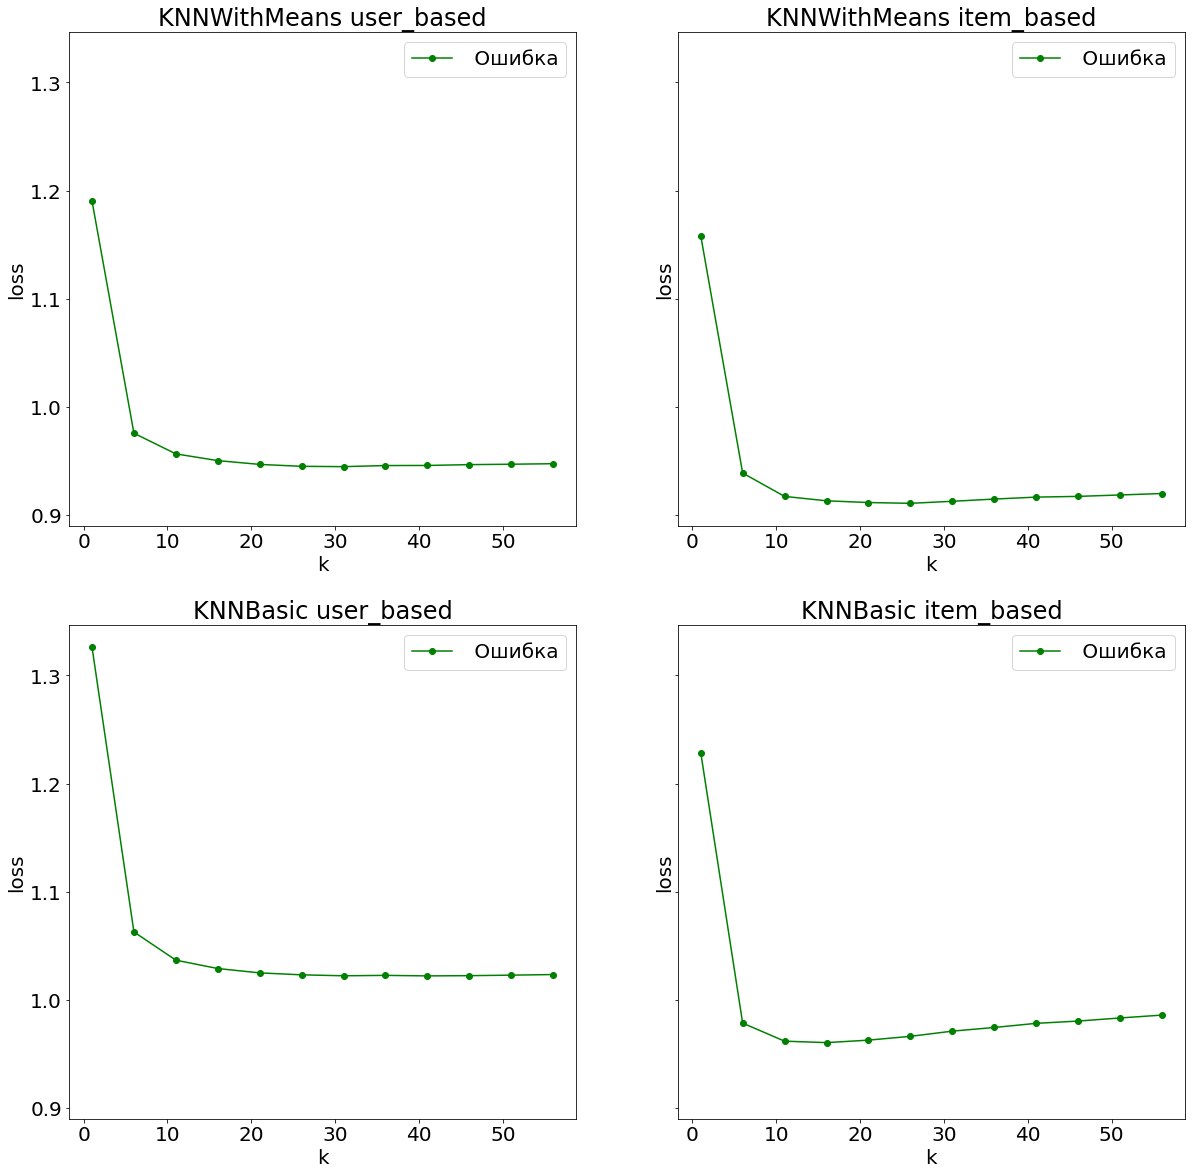

In [229]:
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(2,2, figsize=(20,20), sharex=False, sharey=True)
lst_time = []
time = []
k_max = 60
for i,j in itertools.product(range(2),range(2)):
        algo = "KNNWithMeans" if i == 0 else "KNNBasic"
        user_based = True if j == 0 else False
        
        
        lst_loss = []
        for k in tqdm.trange(1,k_max,5):
            
            knn = KNNWithMeans(k=k,user_based=user_based) if i ==0 else KNNBasic(k=k, user_based=user_based)
            knn.fit(new_df)
            pred = knn.predict(my_pivot)

            loss = np.sqrt((np.array(pred - true_raiting)**2).sum() / len(pred))
            lst_loss.append(loss)


        axes[i,j].plot(range(1,k_max,5), lst_loss, label=f" Ошибка", marker='o', color="green")
        title = algo + " user_based" if user_based else algo + " item_based"
        axes[i,j].set_title(title)
        axes[i,j].legend()

        axes[i,j].set_xlabel("k")
        axes[i,j].set_ylabel("loss")
        


In [ ]:
"""
В дальнейших экспериментах используем лучшие параметры.
Для KNNBasic - 10 соседей, item_based. 
Для KNNWithMeans - 19 соседей, item_based.
"""

# Качество SVD по числу эпох в SGD.

100%|██████████| 48/48 [04:21<00:00,  5.45s/it]


Text(0, 0.5, 'loss')

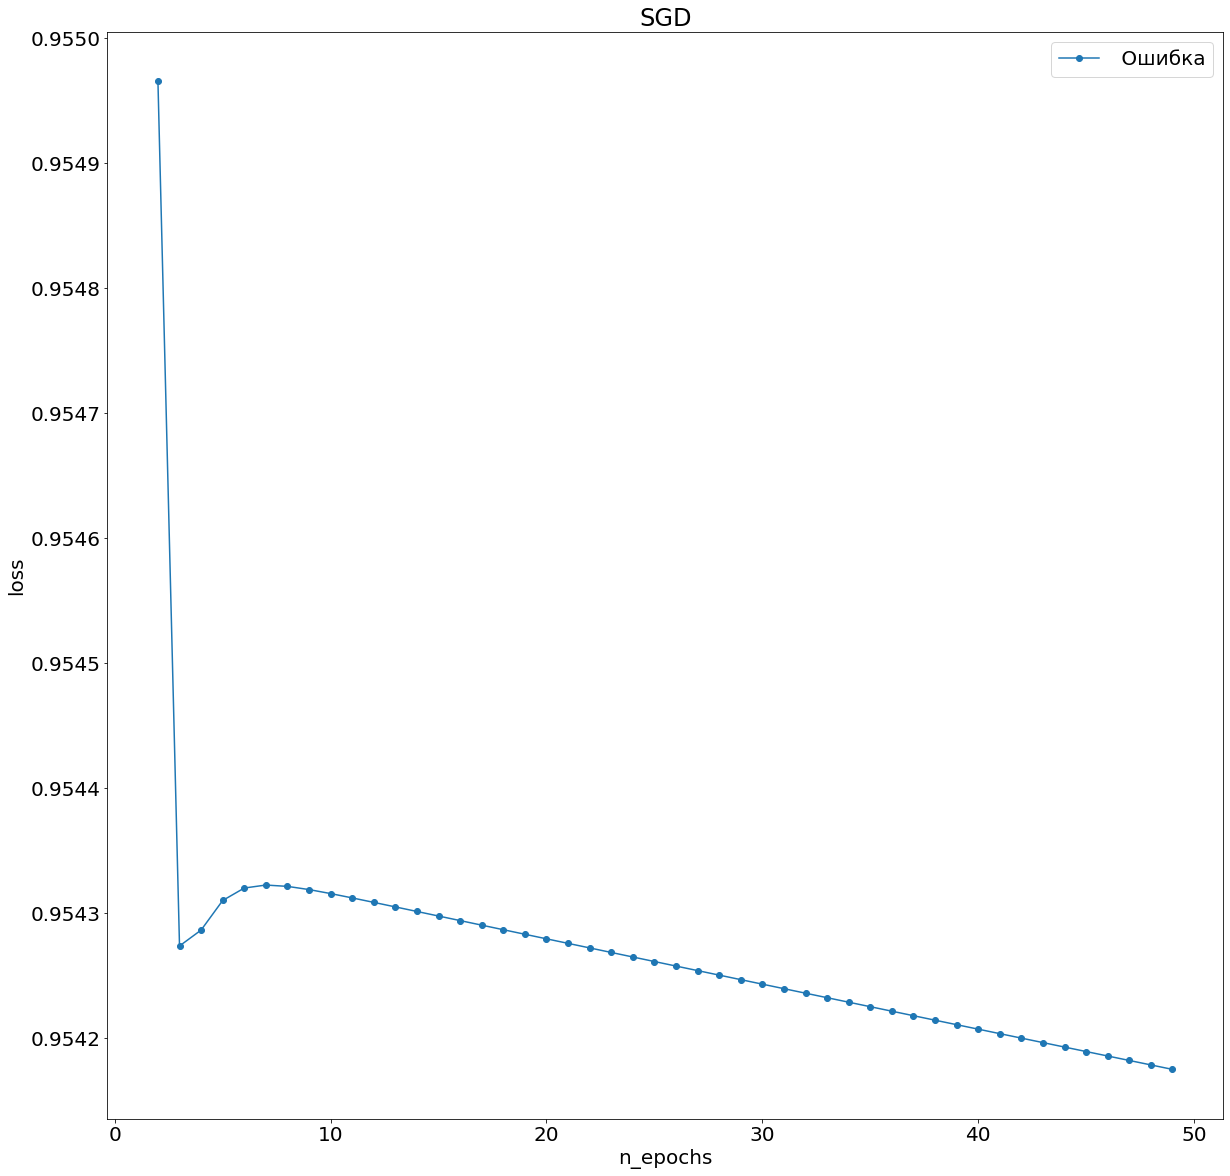

In [251]:
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(1,1, figsize=(20,20), sharex=False, sharey=True)
lst_time = []
time = []
n_epochs = 50

algo = "SGD" 
lst_loss = []
for n in tqdm.trange(2,n_epochs,1):
    svd=SVD(n_factors=2,n_epochs=n)

    svd.fit(new_df)
    pred = svd.predict(my_pivot)
    loss = np.sqrt((np.array(pred - true_raiting)**2).sum() / len(pred))
    lst_loss.append(loss)


axes.plot(range(2,n_epochs,1), lst_loss, label=f" Ошибка", marker='o')

axes.set_title(algo)
axes.legend()

axes.set_xlabel("n_epochs")
axes.set_ylabel("loss")


# Качество SVD по числу факторов.

100%|██████████| 10/10 [00:52<00:00,  5.25s/it]


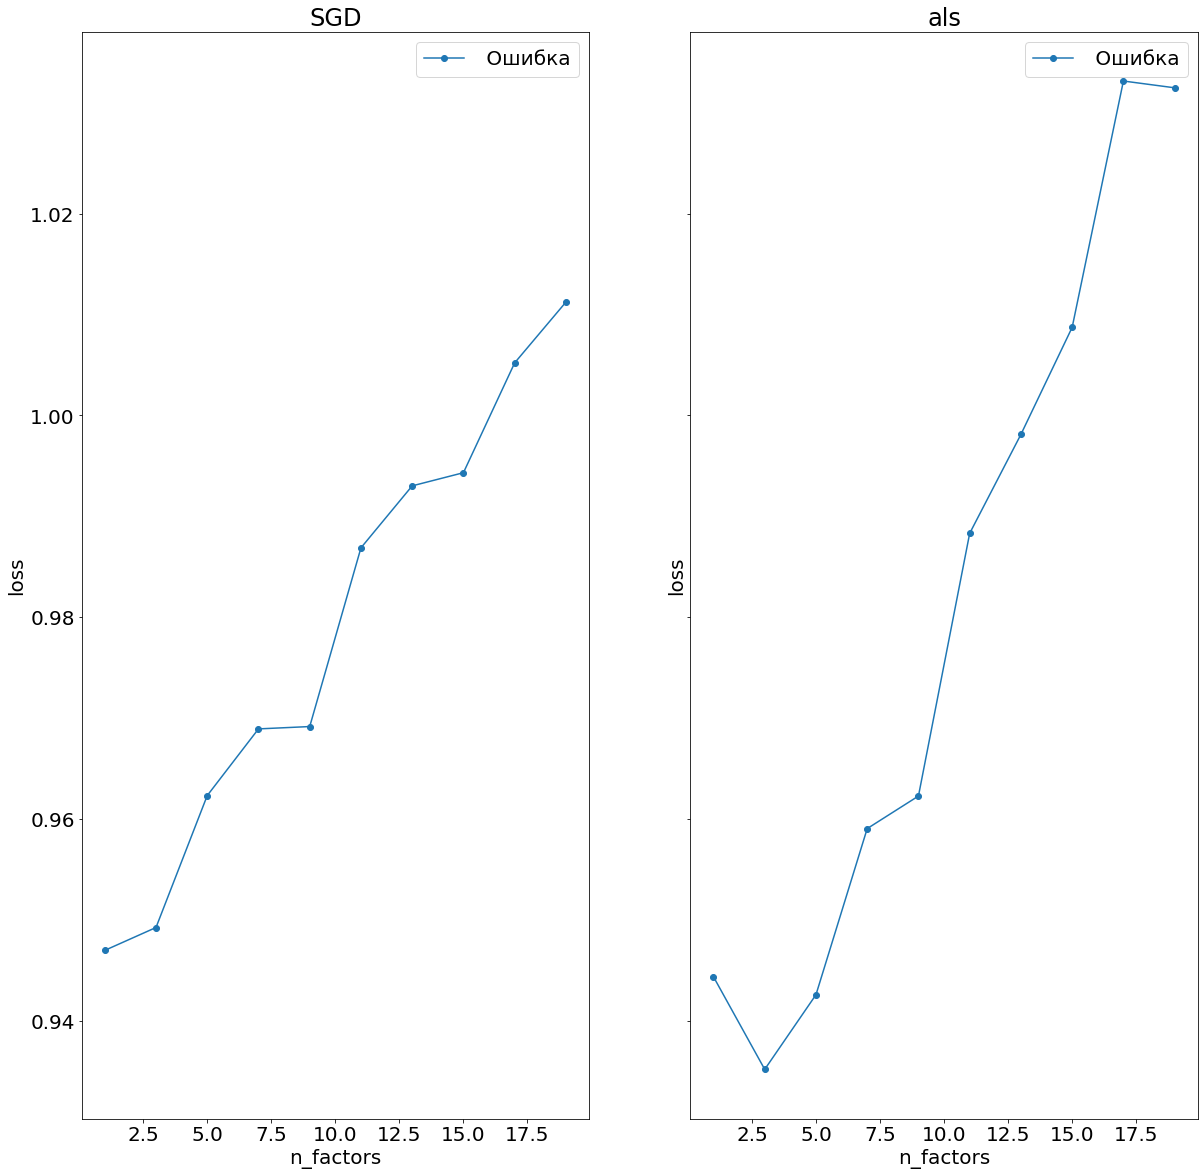

In [239]:
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(1,2, figsize=(20,20), sharex=False, sharey=True)
lst_time = []
time = []
n_factors_max = 20
for i,j in itertools.product(range(1),range(2)):
        algo = "SGD" if j == 0 else "als"
        lst_loss = []
        for n in tqdm.trange(1,n_factors_max,2):
            svd=SVD(n_factors=n,n_epochs=20, method=algo)

            svd.fit(new_df)
            pred = svd.predict(my_pivot)
            loss = np.sqrt((np.array(pred - true_raiting)**2).sum() / len(pred))
            lst_loss.append(loss)


        axes[j].plot(range(1,n_factors_max,2), lst_loss, label=f" Ошибка", marker='o')

        axes[j].set_title(algo)
        axes[j].legend()

        axes[j].set_xlabel("n_factors")
        axes[j].set_ylabel("loss")
        



## Наблюдаем переобучение, с увеличением числа факторов


# Сравниваем ошибки алгоритмов и время работы

In [259]:
import time

In [707]:
"""
Сравнение будем проводить с помощью KFold Validation, количество фолдов = 5
"""

for knn in ["KNNBasic", "KNNWithMeans"]:
    start = time.time()
    val = TestKNN(knn,k=19,user_based=False) if knn == "KNNWithMeans" else TestKNN(knn,k=10,user_based=False)
    print("loss",knn, round(val.KFold_val(5),4), "time spent on validation", round(time.time() - start, 4))

loss KNNBasic 0.9977 time spent on validation 32.0392
loss KNNWithMeans 0.934 time spent on validation 74.4537


In [708]:
"""
Сравнение будем проводить с помощью KFold Validation, количество фолдов = 5
"""
for svd in [SVD(method="SGD", n_epochs=5, n_factors=1), SVD(method="als", n_epochs=5, n_factors=1)]:
    start = time.time()
    print("loss",svd.method, round(svd.KFold_val(k=5),4), "time spent on validation", round(time.time() - start, 4))

loss SGD 0.9491 time spent on validation 22.142
loss als 0.9477 time spent on validation 22.8931


# Выводы
## Получили весьма сходные с опубликованными результатами работы алгоритмов
## SVD работает быстрее KNN. Качество SVD и KNNWithMeans сравнимо, и даже SVD проигрывает, что опять же согласуется с таблицей замеров на валидации с 5 фолдами на датасете ml-100k

# SVD++.
## Следует отметить, что за счет добавления скрытых параметров количество параметров увеличивается на n_factors * |Items|. Поэтому следует использовать только n_factors = 1, иначе будет большое переобучение

In [684]:
class SVDpp:
    def __init__(self, n_factors=1, n_epochs=10, lr=0.002,reg=0.0002,random_state=1):
        self.n_epochs = n_epochs
        self.n_factors = n_factors
        self.reg = reg
        self.random_state = random_state
        self.lr=lr

        
    def sgd(self,df_train):
        np.random.seed(1)
        random.seed(1)
        
        RR = df_train.fillna(0).to_numpy()
        mask = RR != 0
        not_null = mask.sum()

        P = np.random.random((RR.shape[0],self.n_factors))
        Q = np.random.random((self.n_factors,RR.shape[1]))

        us = np.random.random((RR.shape[0],1)) 
        it = np.random.random((1,RR.shape[1])) 

        mu = RR.sum().sum() / not_null
        MU = np.ones_like(RR) * RR.sum() / not_null
        
        mask_yj = RR != 0
        Iu = np.sqrt(mask_yj.sum(axis=1)) 
        
        Y = np.random.random((RR.shape[1],self.n_factors)) 
        
        for _ in range(self.n_epochs):
            for k in range(not_null):
                u = random.choice(range(RR.shape[0]))
                i = random.choice(range(RR.shape[1]))
                if RR[u,i] ==0:
                    continue

                sum_yj_u = ((Y.T @ (np.ones(RR.shape[1])*mask_yj[u]))).T

                e_ui = RR[u,i] - (P[u] + sum_yj_u / Iu[u]) @ Q[:,i] - us[u,0] - it[0,i] - mu 
                P[u] = P[u] + self.lr*(e_ui*Q[:,i].T - self.reg*P[u])
                e_ui = RR[u,i] - (P[u] + sum_yj_u / Iu[u]) @ Q[:,i] - us[u,0] - it[0,i] - mu  
                Q[:,i] = Q[:,i] + self.lr*(e_ui*(P[u].T + sum_yj_u/Iu[u]) - self.reg*Q[:,i])
                e_ui = RR[u,i] - (P[u] + sum_yj_u / Iu[u]) @ Q[:,i] - us[u,0] - it[0,i] - mu 
                us[u,0] = us[u,0] + self.lr * (e_ui - self.reg * us[u,0])
                e_ui = RR[u,i] - (P[u] + sum_yj_u / Iu[u]) @ Q[:,i] - us[u,0] - it[0,i] - mu 
                it[0,i] = it[0,i] + self.lr * (e_ui - self.reg * it[0,i])
                e_ui = RR[u,i] - (P[u] + sum_yj_u / Iu[u]) @ Q[:,i] - us[u,0] - it[0,i] - mu
                Y = Y + 0.0001 * (e_ui*Q[:,i].T - self.reg*Y)

                
        U = us*np.ones_like(RR) 
        I = it*np.ones_like(RR) 
        self.Y = Y 
        self.mu = MU
        self.P = P
        self.Q = Q
        self.I = I
        self.U = U
        self.Iu = Iu


    def fit(self,df_train_):
        np.random.seed(self.random_state)
        df_train = df_train_.copy()
        self.sgd(df_train)

    
    def predict(self,pivot_predict):
        pivot = pivot_predict.copy()
        pred = np.zeros(shape=len(pivot.index))
        restored_R = self.mu + (self.P + (self.Y.T @ mask.T).T / self.Iu.reshape(-1,1))@ self.Q +self.I + self.U
        
        for i in range(len(pivot.index)):
            user, item = list(map(int, list(pivot.iloc[i])))
            
            user -= 1
            item -= 1
            
            pred[i] = restored_R[user,item]
        return pred.clip(1,5)
        


# Соответствующие эксперименты с SVD++

In [712]:
start = time.time()
svd = SVDpp(n_factors=1, n_epochs=200, lr=0.001)
svd.fit(new_df)

train_loss_200 = (((svd.mu + (svd.P + (svd.Y.T @ mask.T).T / Iu.reshape(-1,1))@ svd.Q +svd.I + svd.U -new_df.fillna(0).to_numpy()) * (new_df.fillna(0).to_numpy() !=0))**2).sum()/100000

val_loss = ((svd.predict(my_pivot) - true_raiting)**2).sum() / 5000

In [713]:
print("spent time on n_epochs", time.time() - start)
print("train_loss", train_loss_200)
print("val_loss", val_loss)

spent time on n_epochs 80.4672691822052
train_loss 0.8528160218471148
val_loss 0.9611650501799343


In [722]:
start = time.time()
svd = SVDpp(n_factors=1, n_epochs=300, lr=0.001)
svd.fit(new_df)

train_loss_500 = (((svd.mu + (svd.P + (svd.Y.T @ mask.T).T / Iu.reshape(-1,1))@ svd.Q +svd.I + svd.U -new_df.fillna(0).to_numpy()) * (new_df.fillna(0).to_numpy() !=0))**2).sum()/100000
val_loss = ((svd.predict(my_pivot) - true_raiting)**2).sum() / 5000

In [723]:
print("spent time on ",300, time.time() - start)
print("train_loss", train_loss_500)
print("val_loss", val_loss)

spent time on  300 120.87097930908203
train_loss 0.8337442567369215
val_loss 0.9458894467895234


In [724]:
start = time.time()
svd = SVDpp(n_factors=1, n_epochs=500, lr=0.001)
svd.fit(new_df)

train_loss_500 = (((svd.mu + (svd.P + (svd.Y.T @ mask.T).T / Iu.reshape(-1,1))@ svd.Q +svd.I + svd.U -new_df.fillna(0).to_numpy()) * (new_df.fillna(0).to_numpy() !=0))**2).sum()/100000
val_loss = ((svd.predict(my_pivot) - true_raiting)**2).sum() / 5000

In [725]:
print("spent time on ",500, time.time() - start)
print("train_loss", train_loss_500)
print("val_loss", val_loss)

spent time on  500 200.6659905910492
train_loss 0.8177916453836103
val_loss 0.9289500215283526


In [726]:
start = time.time()
svd = SVDpp(n_factors=1, n_epochs=650, lr=0.001)
svd.fit(new_df)

train_loss_500 = (((svd.mu + (svd.P + (svd.Y.T @ mask.T).T / Iu.reshape(-1,1))@ svd.Q +svd.I + svd.U -new_df.fillna(0).to_numpy()) * (new_df.fillna(0).to_numpy() !=0))**2).sum()/100000
val_loss = ((svd.predict(my_pivot) - true_raiting)**2).sum() / 5000

In [727]:
print("spent time on ",650, time.time() - start)
print("train_loss", train_loss_500)
print("val_loss", val_loss)

spent time on  500 259.67758893966675
train_loss 0.8155530721894477
val_loss 0.9285328098386857


# SVD++ показывает достойные результаты (лучшие из рассмотренных ранее).
## Ошибка на валидации при:
## 200 эпохах - 0.96111
## 300 эпохах - 0.94588
## 500 эпохах - 0.92895
## 650 эпохах - 0.92853
## Однако время работы чрезмерно велико (приведено в соответствующих ячейках).
## За счет того, что используем SGD, сходимость гораздо медленнее, чем ожидается при использовании батчей.